## Описание проекта: </b>
Главной целью работы является отработка принципа работы с данными для прогнозирования рекламных кампаний на следующий год. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт <br>
Будет обработан массив данных, который включает в себя данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', 50) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# параметры для корректного отображения таблиц и более удобного их анализа

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00000,Sports,41.36000,28.96000,3.77000,8.45000,76.00000,8,E
1,Super Mario Bros.,NES,1985.00000,Platform,29.08000,3.58000,6.81000,0.77000,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00000,Racing,15.68000,12.76000,3.79000,3.29000,82.00000,8.3,E
3,Wii Sports Resort,Wii,2009.00000,Sports,15.61000,10.93000,3.28000,2.95000,80.00000,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00000,Role-Playing,11.27000,8.89000,10.22000,1.00000,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Значения года выпуска float, можно заменить на int. значение user_score object, стоит заменить на численное. 

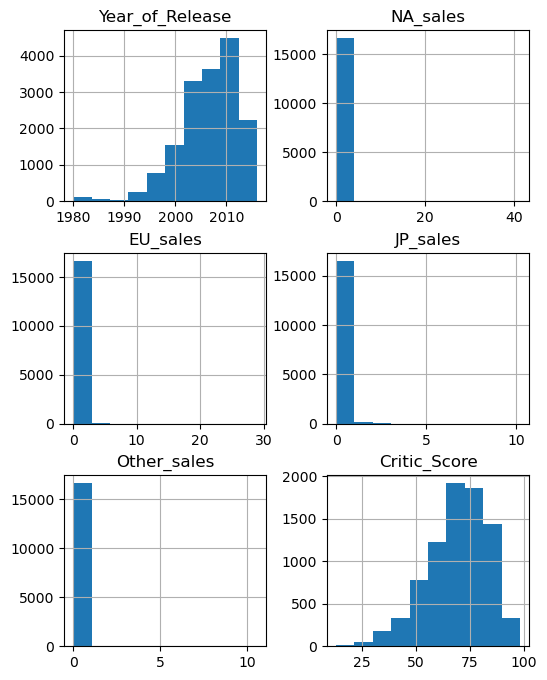

In [6]:
df.hist(figsize=(6,8));

## Предобработка данных

In [7]:
df.columns = df.columns.str.lower() #привели названия колонок к нижнему регистру

In [8]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [9]:
df = df.dropna(subset=['name']).reset_index(drop=True) # убираем строки с пропущенными названиями, так как их всего 2
df = df.dropna(subset=['year_of_release']).reset_index(drop=True) # убираем строки с годом выпуска, т.к. их всего 269 --> 
#проще убрать, чем искать и заполнять каждую строчку реальным значением
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

значения заглушки в столбце с рейтингами

In [10]:
df['rating'] = df['rating'].fillna(value='unknown') #заполняем пропуски в рейтингах, поскольку это понадобится позже при анализе
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

In [11]:
df.loc[(df['user_score'] == 'tbd'), 'user_score'] = np.nan 

df['user_score'] = df['user_score'].astype(float)

Поскольку значений 'tbd' достаточно много(более двух тысяч), то просто удалить все строки с этим значением мы не можем. Также мы не можем заменить это значение на какую-либо цифру(усреднять оценку не стоит, как и заменять на ноль)

In [12]:
df['year_of_release'] = df['year_of_release'].astype(int) #год не может быть дробным, поэтому переводим в целочисленный

In [13]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales'] 
# добавляем столбец суммарных продаж по всем регионам

* Были приведены все названия столбцов к нижнему регистру, для удобства использования.
* Были убраны строки с пропусками в названии и жанре(это оказались одни и те же строки) --> скорее всего ошибка в записи
* Убраны строки с пропусками в годе выпуска. Поскольку их достаточно много для заполнения вручную, но достаточно мало, чтобы ими пожертвовать (269 значений)
* Выявлены значения оценок 'tbd'. Их оказалось достаточно много. Обозначает данная абривеатура "ожидается", следовательно было принято решение заменить их на NaN, т.к. значение отсутствует
* Изменен тип значений в столбце 'user_score', в связи с тем, что был использован тип object, а оценки приведены в цифровых значениях
* Заменены типы значений в колонке 'year_of_release', в связи с тем, что не может быть значения года с дробной частью
* Добавлен столбец суммарных продаж по всем регионам
* Пустых значений в последних трех колонках сильно много, принято решение их не убирать. Заменить их на что-то тоже не представляется возможным. <br>
<font color='blue'> * Были заполнены пустые значения в колонке 'rating' выражением "unknown" для последующей обработки </font>

## Исследовательский анализ данных

array([[<Axes: title={'center': 'year_of_release'}>]], dtype=object)

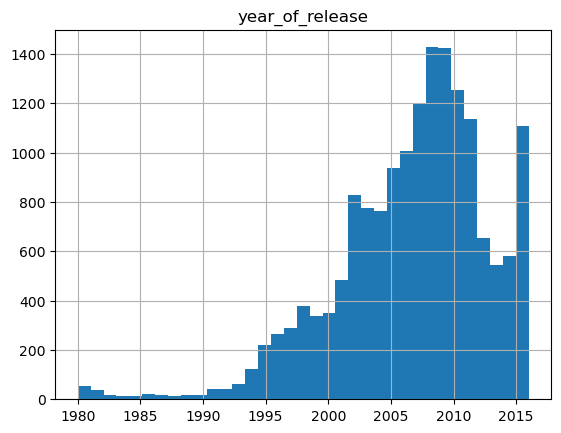

In [14]:
df.hist('year_of_release', bins=35)

Индустрия видеоигр стала активно развиваться в 90ых годах и достигла своего пика в конце нулевых. Стоит отметить выделяющийся маленький пик в начале 80ых, который говорит о том, что тогда игры выпускались для эксперимента и исследования рынка, позже был провал в графике и уже к 95ому году пришло осознание, что производство игр это может стать прибыльным бизнесом. Одной из причин этому стало развитие технологий и возможности качественной визуализации массового продукта.

In [15]:
(
df.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
    .head(10)
)
# выявили топ платформ по суммарным продажам

,sum_sales
platform,
PS2,1233.56000
X360,961.24000
PS3,931.34000
Wii,891.18000
DS,802.78000
PS,727.58000
PS4,314.14000
GBA,312.88000
PSP,289.53000


Посмотрев на распределение топ 10 платформ, были выбраны первые 6 для изучения изменения продаж по годам

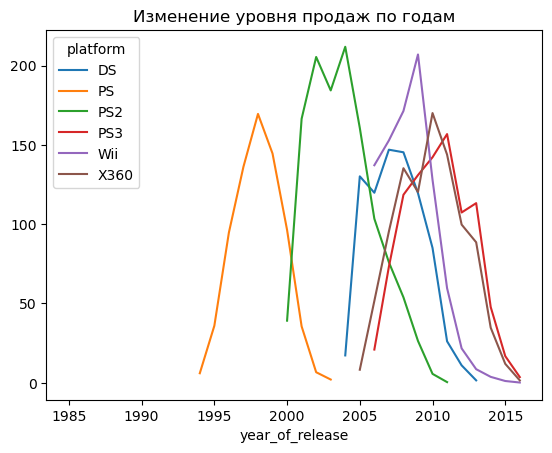

In [16]:
(
df.query('platform in ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot()
);
plt.title("Изменение уровня продаж по годам");
# построили графики изменения продаж по годам для шести самых популярных консолей

Посмотрев на графики изменения продаж по годам для самых популярных консолей, можно сказать, что временной цикл для поколения составляет около 10 лет с момента выпуска и до ухода поколения с рынка. На пик продаж поколение выходит через 2-3 года с момента старта, что связано с задержками в покупке новых консолей, а также с тем, что переход на новое поколение, как правило, происходит постепенно (когда игры выходят на оба поколения консолей одновременно)

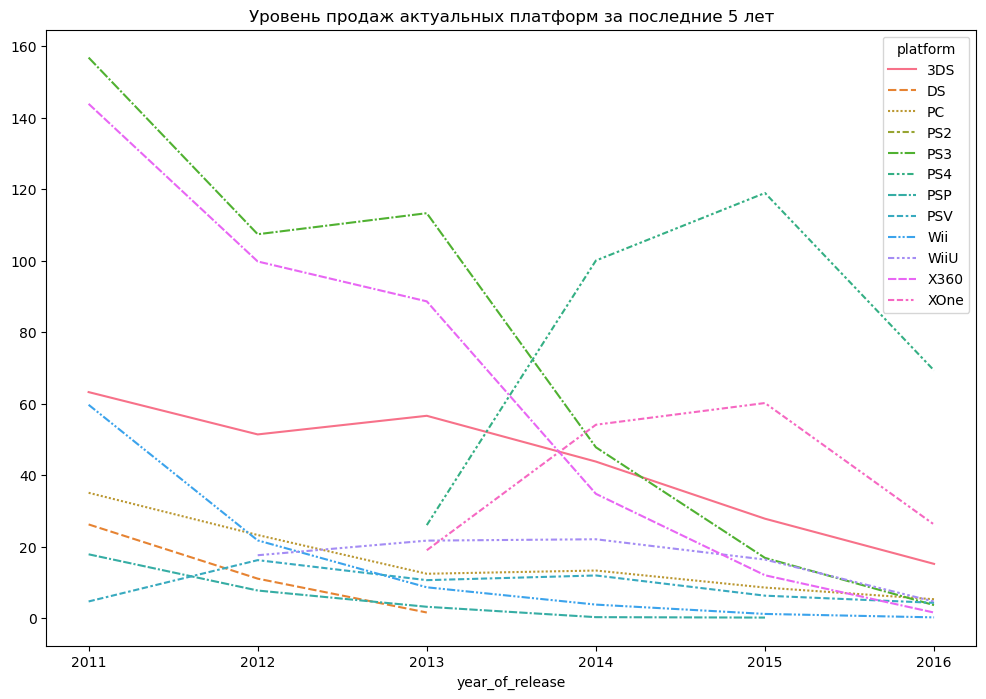

In [17]:
df_actual =(
    df.query('(year_of_release >= 2011)')
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
)
plt.figure(figsize=(12, 8))
sns.lineplot(data= df_actual);
plt.title("Уровень продаж актуальных платформ за последние 5 лет");

Нами были взяты данные за последние пять лет. В этот диапазон попадают данные консолей предыдущего поколения, "промежуточного"(WiiU, PSV) и актуальные. <br>
Целью этого графика было узнать какие платформы лидируют по продажам, какие растут, а какие падают. Также нужно было выделить несколько потенциально прибыльных платформ <br>
Кривые Playstation 3, как и Xbox 360, за выбранный период совершили падение от лидеров рынка до морально устаревшей платформы без игр. Их заменили Playstation 4 и Xbox ONE, которые и являются на данный момент самыми потенциально прибыльными консолями. График игр на ПК показывает стабильное падение показателя (от 40 млн в 2011, до 20 млн в 2016), но стоит отметить, что рынок ПК не привязан к поколениям, а также имеет возможность пиратства --> также может считаться приоритетным в 2017ом, поскольку никогда не устареет(но стоит помнить, что чем меньше затрат на рынок пк, тем больше прибыль из-за пиратства). <br>
Показатели Японских платформ тоже стоит изучать с региональным подходом, так как количество проданных копий на WiiU в принципе не превышает 25 млн копий в год, следовательно при выпуске Японской игры, можно расценивать эту консоль как актуальную(если Nintendo Switch еще не анонсировали). Также стоит отметить показатели Nintendo 3DS, ее значения упали с >60 млн в 2011, до 20< млн в 2016ом. Изменение кривой графика намного ровнее, чем у XOne (нет резкого пика, и резкого падения), соответственно можно сказать, что 3DS все еще актуальна. <br>
Playstation Vita изначально считается неудачной консолью, что показывает график продаж игр, не превысивший отметки 20 млн копий даже в самый прибыльный год --> не актуально

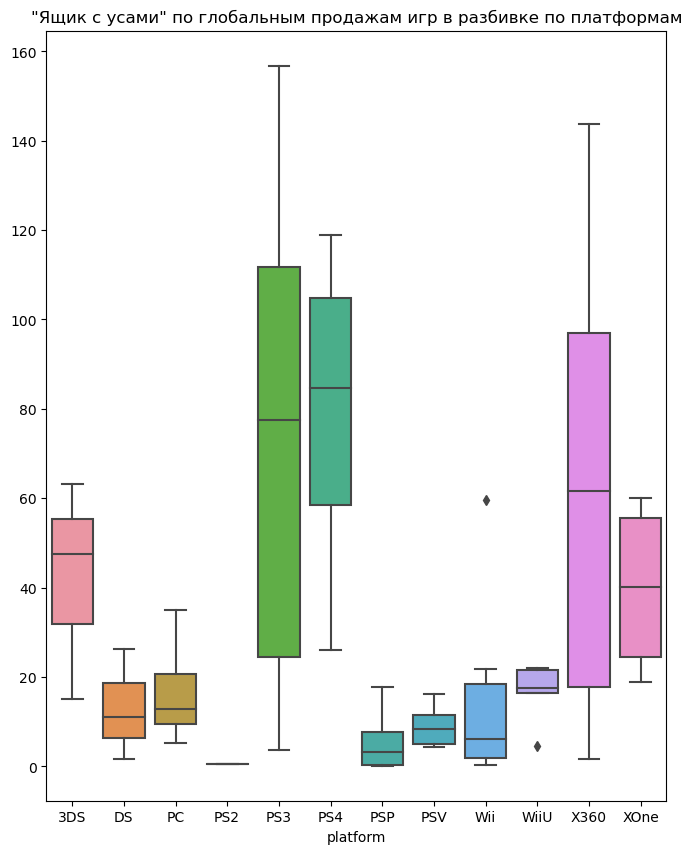

In [18]:
plt.figure(figsize=(8, 10))
plt.title('"Ящик с усами" по глобальным продажам игр в разбивке по платформам');
sns.boxplot(data=df_actual);

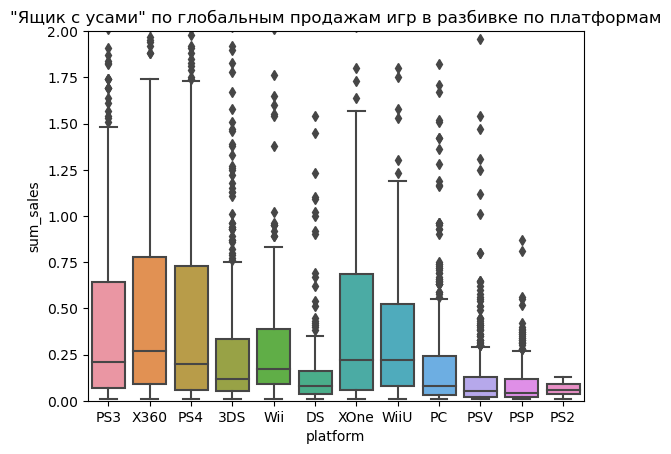

In [19]:
q = df.query('year_of_release >= 2011')
sns.boxplot(data=q, x= 'platform', y='sum_sales');
plt.ylim(0, 2)
plt.title('"Ящик с усами" по глобальным продажам игр в разбивке по платформам');

Самое большое количество копий было продано для PS3 и X360, далее идут PS4 и XOne. Все остальные платформы имеют малую долю продаж за актуальный период. У актуальных платформ медианальное значение схоже со средним, что говорит о рентабельности выпуска игр на эти консоли. Все остальные платформы, которые имеют достаточно малый вклад в суммарное значение продаж имеют ярковыраженное медианное значение, стремящееся к первому квартилю(значит был выброс в один-два года. Возможно это показывает снижение уровня продаж на этих платформах)

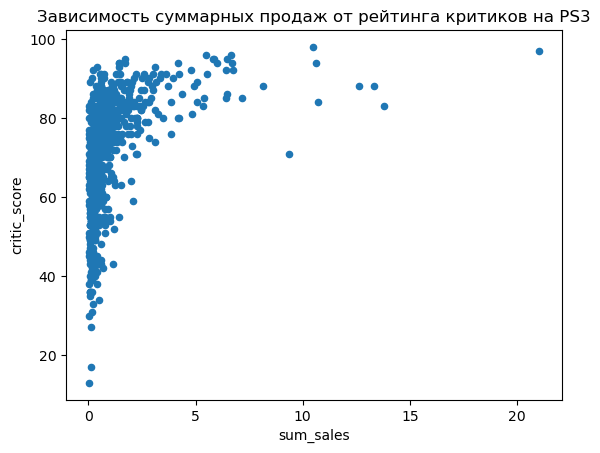

In [20]:
(
    df.query('platform == "PS3"')
    .plot(kind='scatter', x='sum_sales', y='critic_score', title='Зависимость суммарных продаж от рейтинга критиков на PS3')
);

In [21]:
k = df.query('platform == "PS3"')
display(k[['sum_sales', 'critic_score']].corr()) # корреляция значений на графике

,sum_sales,critic_score
sum_sales,1.00000,0.43276
critic_score,0.43276,1.00000


На графике зависимости суммарных продаж от оценок критиков на примере PS3 прослеживается корреляция в сегменте оценок от 75 баллов --> люди покупают то, что получило высокие оценки критиков. Также это отмечается в значениях корреляции (0,43)

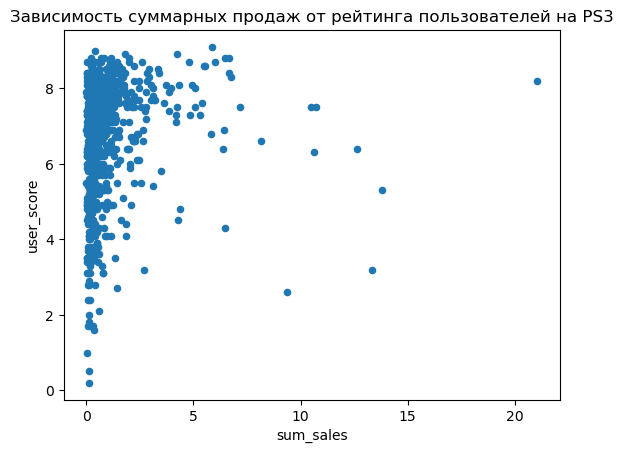

In [22]:
(
df.query('platform == "PS3"')
    .plot(kind='scatter', x='sum_sales', y='user_score', title='Зависимость суммарных продаж от рейтинга пользователей на PS3')
);


In [23]:
a = df.query('platform == "PS3"')
display(a[['sum_sales', 'user_score']].corr())

,sum_sales,user_score
sum_sales,1.00000,0.12842
user_score,0.12842,1.00000


На графике зависимости суммарных продаж от рейтинга пользователей на примере PS3 корреляция менее выражена и становится хоть сколько закономерной от 6 баллов --> критики часто завышают оценки, поэтому игры с высокими рейтингами могут получить низкую оценку пользователей. Однако, если игра получила высокую оценку от пользователей, то она будет более вероятно успешна, чем игра с более низкой. <br>
В цифрах значения корреляции сильно ниже, чем в первом случае

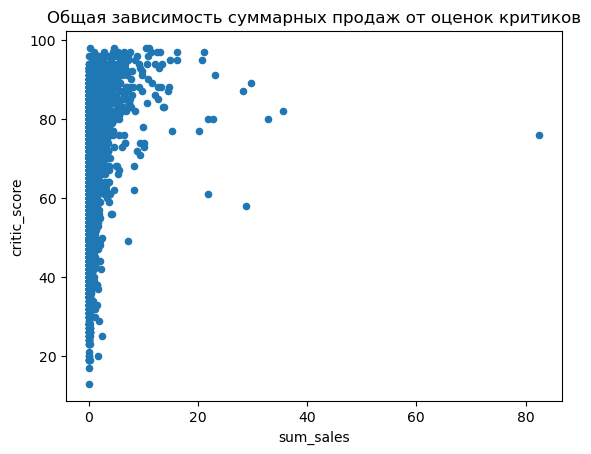

In [24]:
df.plot(kind='scatter', x='sum_sales', y='critic_score', title='Общая зависимость суммарных продаж от оценок критиков');

Прослеживается увеличение зависимости между оценками и продажами на значениях выше 80, как и в PS3, но зависимость не такая яркая

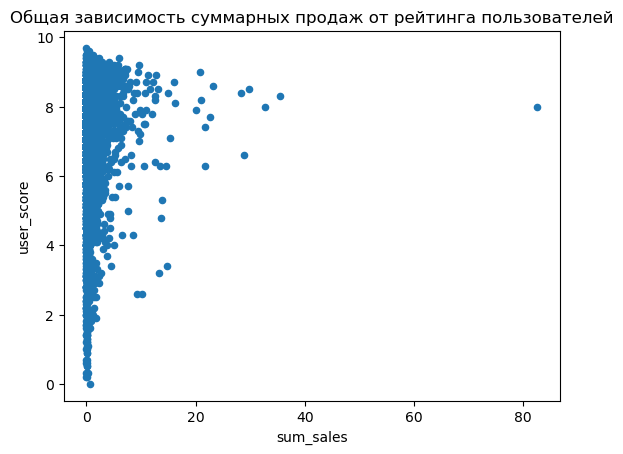

In [25]:
df.plot(kind='scatter', x='sum_sales', y='user_score', title='Общая зависимость суммарных продаж от рейтинга пользователей');

В общем графике зависимости продаж от оценок пользователей корреляция на высоких оценках достаточно высокая и достойная отметки. 

*Гипотеза:* общую картину портит локальный Японский рынок, самые массовые консоли(Playstation, XBox) имеют большую корреляцию в отдельности от всех платформ

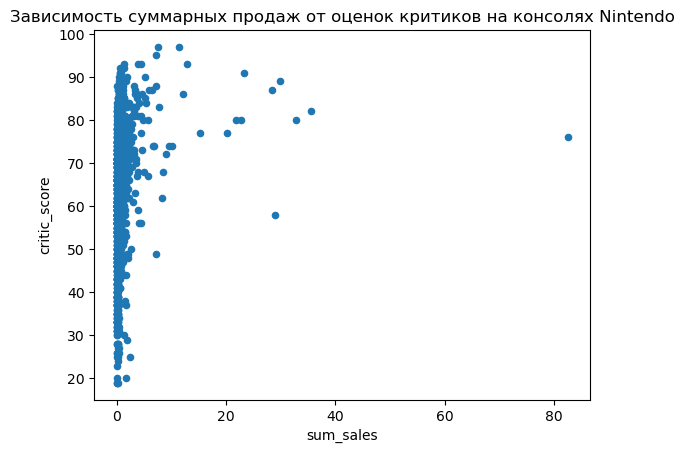

In [26]:
(
    df.query('platform in ["DS", "Wii", "WiiU"]')
    .plot(kind='scatter', x='sum_sales', y='critic_score', title='Зависимость суммарных продаж от оценок критиков на консолях Nintendo')
);

In [27]:
a = df.query('platform in ["DS", "Wii", "WiiU"]')
display(a[['sum_sales', 'critic_score']].corr())

,sum_sales,critic_score
sum_sales,1.00000,0.17921
critic_score,0.17921,1.00000


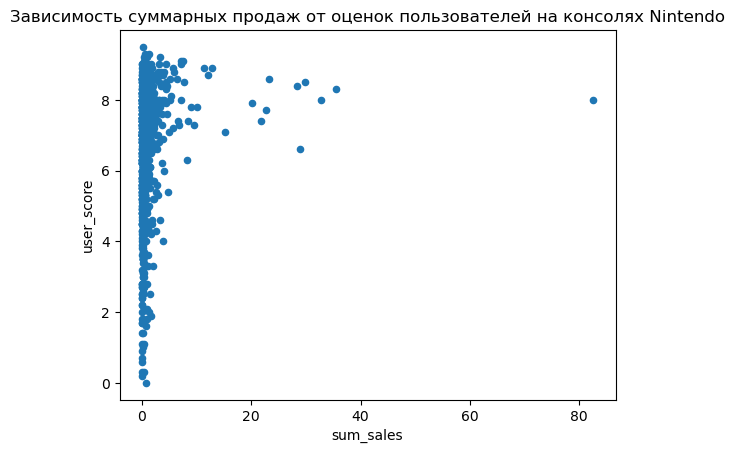

In [28]:
(
    df.query('platform in ["DS", "Wii", "WiiU"]')
    .plot(kind='scatter', x='sum_sales', y='user_score', title='Зависимость суммарных продаж от оценок пользователей на консолях Nintendo')
);

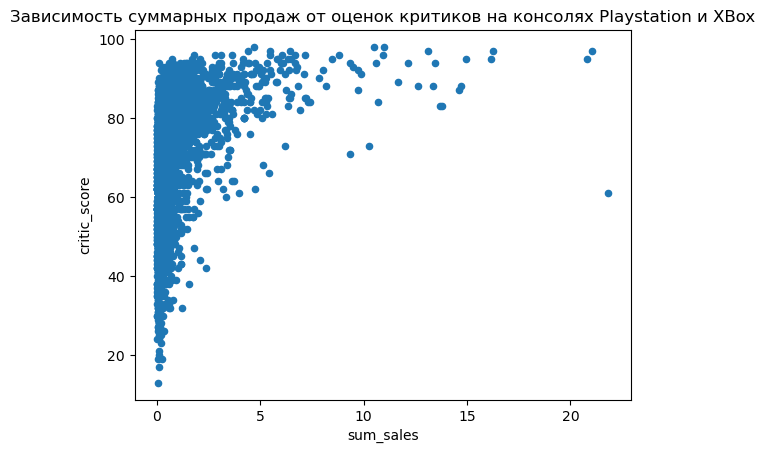

In [29]:
(
df.query('platform in ["PS2", "X360", "PS3", "XOne", "XB", "PS"]')
    .plot(kind='scatter', x='sum_sales', y='critic_score', title='Зависимость суммарных продаж от оценок критиков на консолях Playstation и XBox')
);

In [30]:
b = df.query('platform in ["PS2", "X360", "PS3", "XOne", "XB", "PS"]')
display(b[['sum_sales', 'critic_score']].corr()) 

,sum_sales,critic_score
sum_sales,1.00000,0.38471
critic_score,0.38471,1.00000


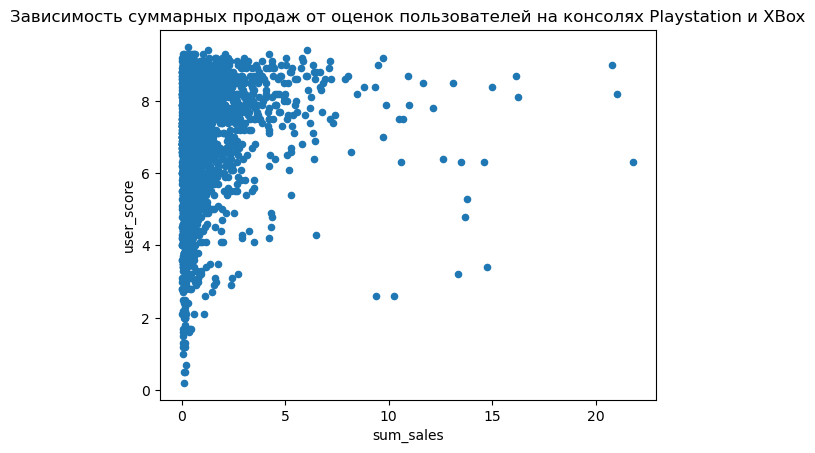

In [31]:
(
df.query('platform in ["PS2", "X360", "PS3", "XOne", "XB", "PS"]')
    .plot(kind='scatter', x='sum_sales', y='user_score', title='Зависимость суммарных продаж от оценок пользователей на консолях Playstation и XBox')
);

In [32]:
b = df.query('platform in ["PS2", "X360", "PS3", "XOne", "XB", "PS"]')
display(b[['sum_sales', 'user_score']].corr())

,sum_sales,user_score
sum_sales,1.00000,0.11290
user_score,0.11290,1.00000


При вычислении корреляции было выявлено, что зависимость продаж игр от оценок пользователей достаточно низкая, в то же время та же зависимость, но относительно оценок критиков гораздо выше. <br>
NB! Стоит ориентироваться на высокие оценки критиков при формировании прогноза рекламной кампании

In [33]:
(
df.pivot_table(index='genre', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
)

,sum_sales
genre,
Action,1716.52000
Sports,1309.67000
Shooter,1041.36000
Role-Playing,931.08000
Platform,825.55000
Misc,790.29000
Racing,723.49000
Fighting,442.66000
Simulation,387.96000


Самый популярный жанр видеоигр это Action, за ним Sports и Shooter. Эти три жанра существуют для отдыха и пользуются наибольшим успехом. Самыми низкими продажами отмечаются Strategy, Adventure и Puzzle, которые представляют собой достаточно сложные в производстве игры, а также в последствии при их воспроизведении, игрок получает экспириенс не для расслабления, а практически наоборот

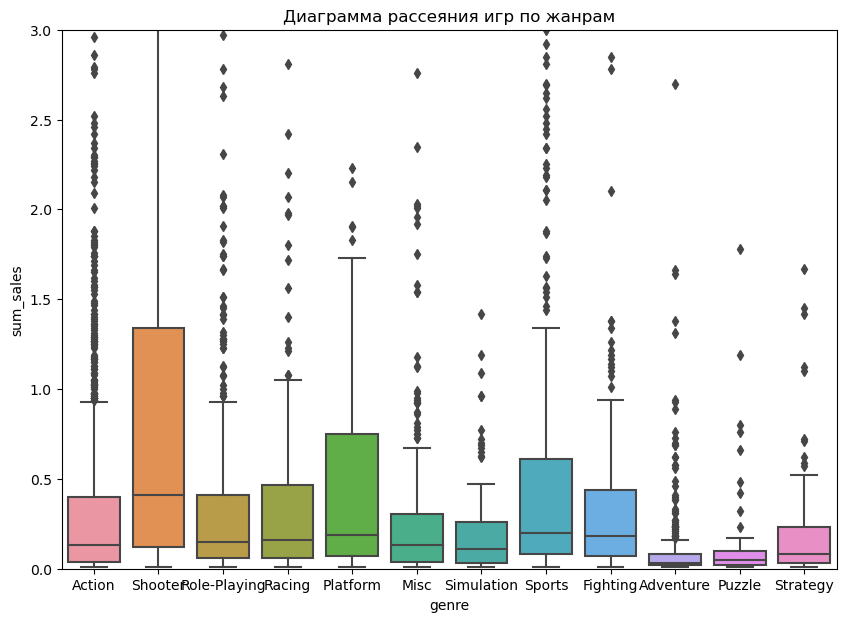

In [34]:
plt.figure(figsize=(10, 7))
g = df.query('year_of_release >= 2011')
sns.boxplot(data=q, x= 'genre', y='sum_sales');
plt.ylim(0, 3);
plt.title('Диаграмма рассеяния игр по жанрам');

По данным таблицы с суммарными значениями, было видно, что самый популярный жанр по продажам это "Action", за ним идет "Sports" и только потом "Shooter". Проанализировав график рассеяния, можно увидеть, что на самом деле в первых двух жанрах существуют игры-бестселлеры, которые делают почти все продажи. Когда, на самом деле, вероятность, что игра окажется прибыльной и популярной в жанре "Shooter" гораздо выше, чем в других. (много шутеров делают большую кассу. один спортивный симулятор делает почти столько же, сколько несколько шутеров. вероятность удачной продажи у шутера больше) <br>
В связи с этим, видно, что медианных продаж также больше у платформеров и игр в жанре "Fighting", которые чаще становятся популярными у пользователей. Также стоит отметить, что в жанре "Action" существует пара бестселлеров, которые приносят больше всего денег, когда медианные продажи достаточно низкие.

## Составление портрета пользователя каждого региона

**Выявить самые популярные платформы в трех регионах**

In [35]:
(
df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
    .head(5)
) # таблица для NA

,na_sales
platform,
X360,595.74000
PS2,572.92000
Wii,486.87000
PS3,390.13000
DS,380.31000


In [36]:
(
df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
    .head(5)
) # таблица для EU

,eu_sales
platform,
PS2,332.63000
PS3,327.21000
X360,268.32000
Wii,258.32000
PS,212.39000


In [37]:
(
df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
    .head(5)
) # таблица для JP

,jp_sales
platform,
DS,175.02000
PS,139.78000
PS2,137.54000
SNES,116.55000
3DS,100.62000


В Европе и Северной Америке популярные платформы схожи между собой. Это PS2, PS3 и Xbox 360, только в разных пропорциях. Если в Америке самой популярной консолью является там же произведенная Xbox 360, с отрывом от PS3 практически в два раза и наравне с PS2. В Европе же более популярными являются консоли фирмы Sony, с отрывом от X360 на 50 млн копий. В каждом из двух регионов присутствует, хотя бы одна платформа фирмы Nintendo. <br> 
В Японии же самые популярные платформы представлены исключительно консолями японского же производства. Это Nintendo DS, Playstation и Playstation 2, а также SNES и Nintendo 3DS, что связано с любовью японцев к играм локального производства, которые не сильно популярны в европе и Сев. Америке

**Выявить самые популярные жанры в трех регионах**

In [38]:
(
df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
    .head(5)
) # таблица для NA

,na_sales
genre,
Action,863.17000
Sports,671.20000
Shooter,584.83000
Platform,444.44000
Misc,399.57000


In [39]:
(
df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
    .head(5)
) # таблица для EU 

,eu_sales
genre,
Action,510.99000
Sports,371.33000
Shooter,314.52000
Racing,234.49000
Misc,210.60000


In [40]:
(
df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
    .head(5)
) # таблица для JP

,jp_sales
genre,
Role-Playing,353.39000
Action,160.14000
Sports,134.93000
Platform,130.71000
Misc,107.02000


Самые популярные жанры во всех трех регионах схожи по концепции и немного разнятся между собой. Это Action, Sports, Platform, Misc. Связано это с тем, что игры используются людьми для получения удовольствия и отсутствия желания думать и страдать. <br>
Особенностью Американского и Европейского рынка является любовь к играм жанра Shooter. В то же время, в Японии с огромным отрывом в 2 раза по количеству проданных копий, опережает второе место жанр Role-Playing, что связано с огромным количеством локальных игр, популярных на японском рынке, именно в жанре Role-Playing

**Влияние рейтинга ESRB на продажи в отдельном регионе**

In [41]:
(
df.pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
    .head(5)
) # таблица для NA

,na_sales
rating,
E,1274.24000
unknown,1225.84000
T,747.60000
M,742.89000
E10+,345.50000


In [42]:
(
df.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
    .head(5)
) # таблица для EU

,eu_sales
rating,
E,703.87000
unknown,609.65000
M,480.00000
T,421.79000
E10+,183.35000


In [43]:
(
df.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
    .head(5)
) # таблица для JP

,jp_sales
rating,
unknown,836.74000
E,197.96000
T,150.70000
M,63.58000
E10+,40.20000


Количество проданных копий с рейтингом "E"(everyone) в каждом регионе самое большое. <br>
В Сев. Америке и в Европе количество копий с рейтингом "M"(mature) и "T"(teen) примерно одинаковое с незначительной разницей. В Японии же количество проданных копий с рейтингом "M" практически в три раза меньше, чем с рейтингом "T". Это связано с тем, что в Японии отличающиеся вкусы относительно Европы и Сев. Америки, что выражается в покупке игр Японского производства, которые достаточно часто с рейтингом "T". <br>
Предпоследнее место занимают игры с рейтингом "E10+"(everyone after 10 years old), что связано с его введением только в 2005ом году и достаточно малым количеством игр. <br>
Последнее место в NA и JP занимает "K-A"(kids to adults), что является просто ранним вариантом рейтинга "E". В Европе же меньше 1 млн копий было продано в категории "AO"(adults only), это рейтинг с достаточно жесткими требованиями к продаже, а также присвоен достаточно ограниченному количеству игр <br>
Особенное значение стоит придать играм без рейтинга. Во всех трех регионах существуют свои системы возрастного рейтинга в играх. В связи с тем, что Японский рынок заполнен локальными играми, соответственно там игры сертифицируются японской классификацией --> большинство игр не имеют рейтинга ESRB, поскольку у них своя система оценки. <br>
 В Европе и Сев. Америке количество копий без рейтинга соразмерно количеству игр с рейтингом "E", что может обозначать отсутствие ограничений по рейтингу --> приравнивание к рейтингу "E"

## Проверка гипотез

**Первая гипотеза** <br>
_Средние пользовательские рейтинги платформ Xbox One и PC одинаковые_ <br>
Альтернативная гипотеза: <br>
Средние пользовательские рейтинги платформ Xbox One и PC не равны

In [44]:
df_act = df.query('year_of_release >= 2011')
results=st.ttest_ind(
    df_act.loc[df_act['platform'] == "XOne", 'user_score'],
    df_act.loc[df_act['platform'] == "PC", 'user_score'],
    equal_var=False, nan_policy='omit')
alpha=0.05

print(f'p-value = {results.pvalue}')
if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 0.6130712247638477
Не получилось отвергнуть нулевую гипотезу


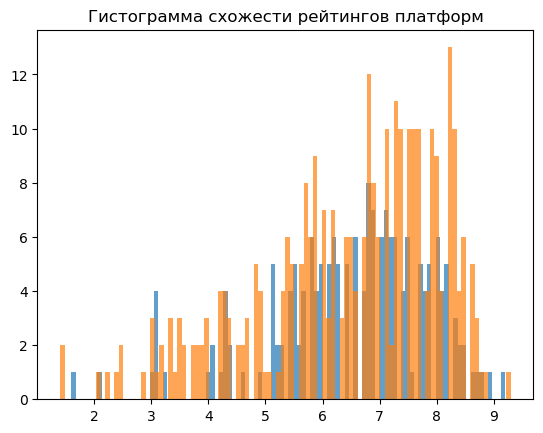

In [45]:
user_score_action = df_act[(df_act['platform'] == 'XOne') & (df_act['user_score'] != 0)]
user_score_sport = df_act[(df_act['platform'] == 'PC') & (df_act['user_score'] != 0)]

plt.hist(user_score_action['user_score'], alpha=0.7, bins=100);
plt.hist(user_score_sport['user_score'], alpha=0.7, bins=100);
plt.title('Гистограмма схожести рейтингов платформ');

_Нулевая гипотезаподтвердилась --> средние пользовательские рейтинги платформ Xbox One и PC близки._

**Вторая гипотеза** <br>
_Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные_ <br>
Альтернативная гипотеза: <br>
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны

In [46]:
results=st.ttest_ind(
    df_act[df_act['genre']=="Action"]['user_score'],
    df_act[df_act['genre']=="Sports"]['user_score'],
    equal_var=False, nan_policy='omit')
alpha=0.05
print(results.pvalue)
if results.pvalue>alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

8.285648549432565e-19
Не получилось отвергнуть нулевую гипотезу


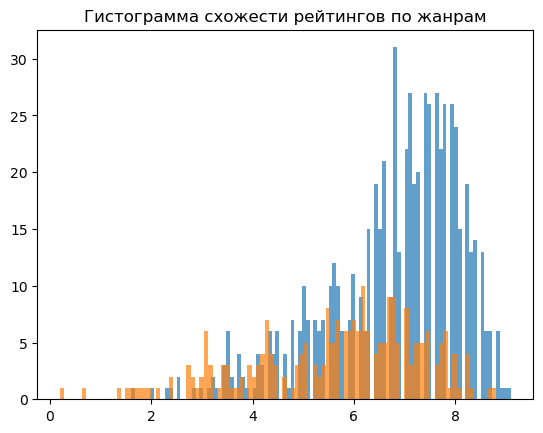

In [47]:
user_score_action = df_act[(df_act['genre'] == 'Action') & (df_act['user_score'] != 0)]
user_score_sport = df_act[(df_act['genre'] == 'Sports') & (df_act['user_score'] != 0)]

plt.hist(user_score_action['user_score'], alpha=0.7, bins=100);
plt.hist(user_score_sport['user_score'], alpha=0.7, bins=100);
plt.title('Гистограмма схожести рейтингов по жанрам');

_Не получилось отвергнуть нулевую гипотезу --> Средние пользовательские рейтинги жанров Action и Sports не близки по значениям_ 

# Общий вывод

В ходе исследования был обработан массив данных, включающий в себя исторические данные по объемам продаж игр (по основным регионам), пользовательским оценкам и оценкам критиков, а также присвоенному рейтингу ESBN. <br>
Массив был приведен к рабочему состоянию путем избавления от некоторых строчек, которые включали в себя пропуски. Также были приведены к удобному формату некоторые колонки с данными и добавлена колонка суммарных продаж игры по миру <br>
В ходе анализа было выявлено, что жизненный цикл актуального поколения платформ, за исключением ПК, составляет около 7-10 лет. Также путем исследования корреляции суммарных продаж от оценок критков и пользователей было выявлено, что игры с высокими оценками продаются более охотно, чем с низкими. <br>
Самой популярной платформой в мире является Playstation. В Японии также выделяется Nintendo, а в Сев. Америке XBOX. <br>
Самыми популярными жанрами, в общем по миру, являются Action и Sports по продажам, но это только за счет игр бестселлеров, которые выбиваются из общей картины. Лучше всего продаются игры в жанре "Shooter", они чаще становятся прибыльными и имеют меньше проходных проектов. Также Японии крайне популярны игры в жанре "RPG", а в Сев. Америке и Европе "Shooter" <br>
Как правило, самым популярным проектом может являться тот, что получил рейтинг ESBN "E". <br>
Как можно было предсказать, рейтинги на Xbox One и на PC достаточно схожи между собой, поскольку эти две платформы не имеют эксклюзивов между собой <br>
Рейтинги между двумя самыми продаваемыми жанрами("Action" и "Sports") очень различаются между собой, что связано с большим количеством проходных проектов в жанре "Action", которые сильно портят статистику<br>
Стоит отметить, что Японский рынок является достаточно замкнутым в себе, что следует учитывать в организации рекламных кампаний. Общие тренды и популярные игры, которые известны в Европе и Сев. Америке могут не соответствовать тому, что происходит на востоке. <br>

</b> 

Анализ массива может быть использован для прогнозирования продаж игр на следующий год 